# Programming Exercise 4:
## Neural Networks Learning

### Introduction

In this exercise, you will implement the backpropagation algorithm for neural
networks and apply it to the task of hand-written digit recognition. Before
starting on the programming exercise, we strongly recommend watching the
video lectures and completing the review questions for the associated topics.

In [1]:
# import necessary libraries
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.io import loadmat # for MATLAB/OCTAVE .mat file -> data
import scipy.misc # displax matrix as a picture/image
import matplotlib.cm as cm # colormap for image display
import random 
import scipy.optimize as opt 
import itertools
from scipy.special import expit # Vectorized sigmoid function

### Visualizing data

In [2]:
# load data
data = loadmat('ex4data1.mat')
X = data['X'] 
y = data['y']
# add intercept term
X = np.insert(X, 0, 1, axis=1)

In [3]:
print("X shape: ", X.shape)
print("y shape: {}. List of labels: {}".format(y.shape, np.unique(y)))
print("Label 10 in data set corresponds to 0 in image.")

X shape:  (5000, 401)
y shape: (5000, 1). List of labels: [ 1  2  3  4  5  6  7  8  9 10]
Label 10 in data set corresponds to 0 in image.


In [4]:
def createImg(row, height, width):
    """
    in: row -> single numpy array, dim: 1xn
        height -> int, image height
        width -> int, image width
    out: image object in matrix form, dim height x width
    """
    img_mat = row[1:].reshape(width,height)
    return img_mat.T

def displayData(X, width=20, height=20, col=10, row=10):
    """
    desc: displays images of matrix data (random rows, 1 row -> 1 image)
    in: X -> data matrix
        height -> int, image height
        width -> int, image width
        col -> int, number of columns
        row -> int, number of rows
    out: data image    
    """
    size = col * row # number of images
    # random select of indices to display
    display_ind = random.sample(range(X.shape[0]), size)
    
    # initial image (empty)
    init_img = np.zeros((width * col, height * row))
    
    row_i, col_i = 0, 0 
    for i in display_ind:
        if col_i == col:
            row_i += 1
            col_i = 0
        img = createImg(X[i], height, width)
        # insert image
        init_img[row_i*height:row_i*height+img.shape[0], col_i*width:col_i*width+img.shape[1]] = img
        col_i += 1
    figure = plt.figure(figsize=(6, 6))
    final_img = scipy.misc.toimage(init_img)
    plt.imshow(final_img, cmap=cm.Greys_r)
    plt.axis('off')

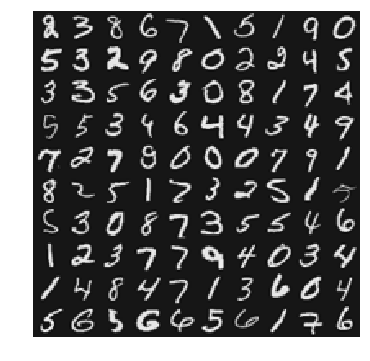

In [5]:
displayData(X)

In [6]:
# load pretrained weights fo NN
weights = loadmat('ex4weights.mat')
theta1 = weights['Theta1']
theta2 = weights['Theta2']

# global variables
In_len = theta1.shape[1] # 400 + 1 bias unit
Hidd_len = theta1.shape[0]
Hidd_bias_len = theta2.shape[1] # 25 + 1 bias unit
Out_len = theta2.shape[0]
Num_samples = X.shape[0]

print("Shape of theta1 is ", theta1.shape)
print("Shape of theta2 is", theta2.shape)
print("Input layer has {} units.\nHidden layer has {} units.\n"
      "Output layer has {} units.".format(X.shape[1] - 1, theta1.shape[0], theta2.shape[0]))

Shape of theta1 is  (25, 401)
Shape of theta2 is (10, 26)
Input layer has 400 units.
Hidden layer has 25 units.
Output layer has 10 units.


In [7]:
# sigmoid function
def sigmoid(x):
    return 1 / (1 - np.exp(-x))

In [8]:
# flatten function, for flattening theta matrix
def flattenTheta(thetaMatrix):
    """
    desc: flattens input theta matrix into array of dim nx1 (1D array)
    in: theta matrix 
    out: 1D array of theta matrix elements    
    """
    thetaLen = In_len * Hidd_len + Hidd_bias_len * Out_len
    flattenList = [thetaRow.flatten() for thetaRow in thetaMatrix] # list of rows, one row -> one elem.
    combine = list(itertools.chain.from_iterable(flattenList)) # combines all elem. in list 
    if len(combine) == thetaLen:
        return np.array(combine).reshape((len(combine), 1))
    else:
        print("Error, number of theta param. doesn't match!")
        
# reshape function for reshaping theta matrix fro 1D array         
def reshapeTheta(f_array):
    """
    desc: reshapes flattened array of theta to theta matrix
    in: theta 1D array
    out: theta matrix    
    """
    theta1_len = In_len * Hidd_len
    # theta2_len= Hidd_bias_len * Out_len
    
    theta1 = f_array[:theta1_len].reshape((Hidd_len, In_len))
    theta2 = f_array[theta1_len:].reshape((Out_len, Hidd_bias_len))
    
    return [theta1, theta2]

def flattenX(in_X):
    return np.array(in_X.flatten()).reshape(Num_samples * In_len, 1)

def reshapeX(in_x):
    return np.array(in_x).reshape(Num_samples, In_len)

### Feedforward NN and cost

In [9]:
def cost(flat_theta, flat_x, y, lambda_= 0):
    """
    desc: computes cost of feedForward NN
    in: flattened theta parameters and X matrix (data), y labels, lambda regularized term 
    out: cost of hypozhesis function for given theta parameters
    """
    theta = reshapeTheta(flat_theta)
    X = reshapeX(flat_x)
    t_cost = 0 # initial cost
    m = Num_samples
    
    for row_i in range(m):
        row = X[row_i]
        # compute value of hypothesis
        h_x = forwPropagation(row, theta)[-1][1]
        # construct temp. y-vector with value '1' in row_i position
        temp_y = np.zeros((10, 1))
        temp_y[y[row_i] - 1] = 1 
        # compute cost of hipothesis value and temp. y value
        cost_i = -1 * temp_y.T.dot(np.log(h_x)) - (1 - temp_y.T).dot(np.log(1 - h_x))
        # sum all cost_i
        t_cost += cost_i
    # normalize cost
    t_cost = (t_cost) / (m * 1.0)
    # compute regularization term
    reg = 0
    for theta_i in theta:
        reg += np.sum(theta_i * theta_i)
    reg *=  lambda_ / (2.0 * m)
    
    return t_cost + reg    

In [10]:
def forwPropagation(x_row, theta_row):
    """
    desc: forward propagation of NN, assumes that bias is already included
    in: row of features (list) for coresponding row of theta values(list)
    return: vector with elem. [0] for hidden layer and elem. [1] for output layer    
    """
    
    features = x_row
    # z values per layer
    z_layer = list()
    for i in range(len(theta_row)):
        # i-th elem. in row of Theta matrix
        theta_i = theta_row[i]
        # z value for single theta and feature vector
        z = theta_i.dot(features).reshape((theta_i.shape[0], 1))
        a = expit(z)
        z_layer.append((z, a))
        if i == len(theta_row) - 1:
            return np.array(z_layer)
        # add bias in a
        a = np.insert(a, 0, 1)
        # propagate forw.
        features = a

In [11]:
# using the loaded set of parameters Theta1 and Theta2,
# we should see that the cost is about 0.287629
thetas = [theta1, theta2]
# compute cost with initial theta param. and lambda = 0
J = cost(flattenTheta(thetas), flattenX(X), y)
print("Cost for initial Theta param. is ", J[0][0])

Cost for initial Theta param. is  0.287629165161


In [12]:
# cost of initial theta param. with reg. term lambda = 1
# we should see that the cost is about 0.383770
J = cost(flattenTheta(thetas), flattenX(X), y, 1)
print("Cost for initial Theta param. and lambda = 1 is ", J[0][0])

Cost for initial Theta param. and lambda = 1 is  0.384487796243


### Backpropagation

In [13]:
# gradient of sigmoid function
def gradSigmoid(x):
    return expit(x) * (1 - expit(x)) 

In [14]:
# random initialization/generation of theta parameters
def genTheta():
    epsilon = 0.1
    theta1_shape = (Hidd_len, In_len) 
    theta2_shape = (Out_len, Hidd_bias_len)
    rand_theta = [np.random.rand(*theta1_shape) * 2 * epsilon - epsilon,
                 np.random.rand(*theta2_shape) * 2 * epsilon - epsilon]
    return rand_theta

In [15]:
# backpropagation function for computing partial derivates in
# hidden layers of NN
def backProp(flat_theta, flat_x, y, lambda_= 0):
    """
    desc: computes partial derivates of hidden layers which
    are then used for opimizing cost function and optimized theta param.
    in: flattened theta vector, flattened X matrix, y vector and lambda_ reg. term
    out: flattened vector of matrix with partial derivates    
    """
    
    # unroll theta param. and X features
    theta = reshapeTheta(flat_theta)
    features = reshapeX(flat_x)
    
    # delta matrices which have all partial deriv. of all elem. in hidden layers
    # matrices also contain bias unit
    delta1 = np.zeros((Hidd_len, In_len)) # 25x401
    delta2 = np.zeros((Out_len, Hidd_bias_len)) # 10x26
    m = Num_samples 
    
    for row_i in range(m):
        row = features[row_i]
        a1 = row.reshape((In_len, 1)) # 401x1
        # forward propagation
        fProp = forwPropagation(row, theta)
        z2 = fProp[0][0]
        a2 = fProp[0][1]
        z3 = fProp[1][0]
        a3 = fProp[1][1]
        # construct temp. y-vector with value '1' in row_i position
        temp_y = np.zeros((10, 1))
        temp_y[y[row_i] - 1] = 1
        delta_3 = a3 - temp_y
        delta_2 = theta[1].T[1:,:].dot(delta_3) * gradSigmoid(z2)
        a2 = np.insert(a2, 0, 1, axis=0)
        delta1 += delta_2.dot(a1.T)
        delta2 += delta_3.dot(a2.T)
    
    D1 = delta1 / (1.0 * m)
    D2 = delta2 / (1.0 * m)
    
    # regularization
    D1[:,1:] = D1[:,1:] + ((1.0 * lambda_) / m) * theta[0][:,1:]
    D2[:,1:] = D2[:,1:] + ((1.0 * lambda_) / m) * theta[1][:,1:]
    
    return flattenTheta([D1, D2]).flatten()

In [16]:
# compute gradient (D) matrix
flat_D = backProp(flattenTheta(thetas), flattenX(X), y, lambda_=0)
d1, d2 = reshapeTheta(flat_D)

In [17]:
# check gradient 
def checkGrad(theta, D, X, y, epsilon = 0.0001, lambda_=0, m=15):
    """
    desc: selects m random elements and verifies if position ij in 
          D matrix (gradient matrix)  is a good estimate of gradient
    in: theta matrix, D matrix, X matrix, y vector and lambda_ reg. parameter
    out: /
    """
    
    flat_theta = flattenTheta(theta)
    flat_D = flattenTheta(D)
    flat_X = flattenX(X)
    num_elem = len(flat_theta)
    
    for i in range(m):
        j = int(np.random.rand() * num_elem)
        epsilon_vec = np.zeros((num_elem, 1))
        epsilon_vec[j] = epsilon
        # high value
        high = cost(flat_theta + epsilon_vec, flat_X, y, lambda_)
        # low value
        low = cost(flat_theta - epsilon_vec, flat_X, y, lambda_)
        # value of numerical gradient 
        grad = (high - low) / (2.0 * epsilon)  
        # value of gradient in D matrix
        grad_d = flat_D[j]
        # print difference
        print("Element: {}  Num grad.: {}  Backprop grad.: {}\nDifference: {}".
              format(j, grad[0][0], grad_d[0], abs(grad[0][0] - grad_d[0])))

In [18]:
checkGrad(thetas, [d1, d2], X, y)

Element: 6801  Num grad.: 4.302166678460395e-06  Backprop grad.: 4.302166072587838e-06
Difference: 6.058725569857426e-13
Element: 2292  Num grad.: -3.994668762441478e-06  Backprop grad.: -3.994672425618695e-06
Difference: 3.6631772173446354e-12
Element: 8213  Num grad.: -0.00040300061621145744  Backprop grad.: -0.00040300061975885376
Difference: 3.547396317665763e-12
Element: 9435  Num grad.: 0.00010082905094188632  Backprop grad.: 0.00010082905058490263
Difference: 3.569836890286379e-13
Element: 1209  Num grad.: -5.3768606234072536e-06  Backprop grad.: -5.376860325221711e-06
Difference: 2.98185542589298e-13
Element: 6499  Num grad.: 2.4458207681377075e-06  Backprop grad.: 2.4458207522484494e-06
Difference: 1.5889258123482925e-14
Element: 3444  Num grad.: 3.6317071572256054e-05  Backprop grad.: 3.6317076800354594e-05
Difference: 5.228098539484215e-12
Element: 6001  Num grad.: 4.769674932791901e-06  Backprop grad.: 4.769674341607935e-06
Difference: 5.911839655238938e-13
Element: 1705  N

#### Learning parameters using nonlinear conjugate gradient algorithm (fmin_cg)

In [19]:
def train(lambda_=0):
    """
    desc: function generates random theta (initial parameters) matrix and optimizes it
    in: lambda_ regularization value
    out: returns a list of two optimized and reshaped theta matrices
    """
    
    flat_randTheta = flattenTheta(genTheta())
    opti = opt.fmin_cg(cost, x0=flat_randTheta, fprime=backProp,
                     args=(flattenX(X), y, lambda_), maxiter=100, disp=True, full_output=True)
    
    return reshapeTheta(opti[0])

In [20]:
# learn theta parameters
learn_theta = train()

         Current function value: 0.060370
         Iterations: 100
         Function evaluations: 250
         Gradient evaluations: 250


In [21]:
# prediction
def predict(x_row, theta):
    """
    desc: function propagates row of features through NN 
    in: x_row (row of features in X matrix), theta matrix
    out: returns predicted value (integer) for given hand writen picture/image of integer
    """
    num_classes = list(range(1,11))
    predict = forwPropagation(x_row, theta)
    
    return num_classes[np.argmax(predict[-1][1])]

def accuracy(X, theta, y):
    """
    desc: for every image computes if prediction is correct or not, also computes efficiency of
    trained NN
    in: X matrix (features), theta matrix (parameters) and y (labels) vector
    out: /
    """
    
    num_correct = 0
    num_total = X.shape[0]
    
    for row_i in range(num_total):
        if int(predict(X[row_i], theta)) == int(y[row_i]):
            num_correct += 1
    acc = (num_correct / num_total) * 100 
    print("Accuracy of trained model: {:.2f}%\nCorrect predictions: {}\nAll examples: {}".
          format(acc, num_correct, num_total))
    

In [22]:
accuracy(X, learn_theta, y)

Accuracy of trained model: 99.74%
Correct predictions: 4987
All examples: 5000


In [24]:
# try different values of reg. lambda
lambda_val = [0.01, 0.05, 0.1, 0.5, 1.0]
for val in lambda_val:
    theta_learned = train(val)
    accuracy(X, theta_learned, y)
    print(f"Lambda value: {val}")
    print("**********")

         Current function value: 0.063705
         Iterations: 100
         Function evaluations: 251
         Gradient evaluations: 251
Accuracy of trained model: 99.72%
Correct predictions: 4986
All examples: 5000
Lambda value: 0.01
**********
         Current function value: 0.104223
         Iterations: 100
         Function evaluations: 247
         Gradient evaluations: 247
Accuracy of trained model: 99.58%
Correct predictions: 4979
All examples: 5000
Lambda value: 0.05
**********
         Current function value: 0.159228
         Iterations: 100
         Function evaluations: 234
         Gradient evaluations: 234
Accuracy of trained model: 99.10%
Correct predictions: 4955
All examples: 5000
Lambda value: 0.1
**********
         Current function value: 0.275920
         Iterations: 100
         Function evaluations: 225
         Gradient evaluations: 225
Accuracy of trained model: 98.56%
Correct predictions: 4928
All examples: 5000
Lambda value: 0.5
**********
         Current f